<a href="https://colab.research.google.com/github/Ron-Wu/deep-learning-test/blob/main/02face_identification_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [3]:
!pip install mtcnn
# !pip uninstall h5py
!pip install h5py==2.10.0
!pip install pprintpp

In [4]:
# Download and unzip dataset
# 下載、解壓縮 dataset
!gdown --id 1RJ6MEDV9tYexOTAQDiWZ2bx8fO4HuUAu
!unzip -q "5celeb.zip"

Downloading...
From: https://drive.google.com/uc?id=1RJ6MEDV9tYexOTAQDiWZ2bx8fO4HuUAu
To: /content/5celeb.zip
2.73MB [00:00, 86.0MB/s]


In [5]:
# 引用套件
import mtcnn
from mtcnn import MTCNN
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm.auto import tqdm
from glob import glob
from tensorflow import keras
from tensorflow.keras.layers import Input, Lambda, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
import tensorflow.keras.backend as K
from pprint import pprint

In [6]:
FOLDER_PATH = '.'
# 定義圖片大小
IMG_SIZE = 160

In [7]:
detector = MTCNN()
path_train = sorted(glob(os.path.join(FOLDER_PATH, '5celeb/data/train/*/*.jpg')))
path_val = sorted(glob(os.path.join(FOLDER_PATH, '5celeb/data/val/*/*.jpg')))
len(path_train), len(path_val)
print(type(path_train), type(path_val))
pprint(path_val)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
<class 'list'> <class 'list'>
['./5celeb/data/val/ben_afflek/httpabsolumentgratuitfreefrimagesbenaffleckjpg.jpg',
 './5celeb/data/val/ben_afflek/httpafilesbiographycomimageuploadcfillcssrgbdprgfacehqwMTENDgMDUODczNDcNTcjpg.jpg',
 './5celeb/data/val/ben_afflek/httpbpblogspotcomedLMjVpRGkSWexgsXjkNIAAAAAAAADWgFFtAUqBlhAsjpg.jpg',
 './5celeb/data/val/ben_afflek/httpcsvkmeuaafdfjpg.jpg',
 './5celeb/data/val/ben_afflek/httpcsvkmeuadecafjpg.jpg',
 './5celeb/data/val/elton_john/httpafilesbiographycomimageuploadcfillcssrgbdprgfacehqwMTEODAOTcxNjcMjczMjkzjpg.jpg',
 './5celeb/data/val/elton_john/httpcdncdnjustjaredcomwpcontentuploadsheadlineseltonjohnemmysperformancewatchnowjpg.jpg',
 './5celeb/data/val/elton_john/httpcdncdnjustjaredcomwpcontentuploadsheadlineseltonjohnstillstandingbrooklynnewyearsjpg.jpg',
 './5celeb/data/val/elton_john/httpcdncdnjustjaredcomwpcontentuploadsheadlineseltonjohnsupportsbrucejennerstra

In [13]:
# extract names
# 方法一
# names = []
# for path in path_train:
#     name = path.split(os.sep)[-2]
#     if name not in names:
#         names.append(name)
# names

# 方法二
name_s = set()
for p in path_val:
  name = p.split("/")[4]
  name_s.add(name)
names = sorted(list(name_s))
names

['ben_afflek', 'elton_john', 'jerry_seinfeld', 'madonna', 'mindy_kaling']

In [14]:
#build class map
cls_map = {}
for i, name in enumerate(names):
    cls_map[name] = int(i)
cls_map

{'ben_afflek': 0,
 'elton_john': 1,
 'jerry_seinfeld': 2,
 'madonna': 3,
 'mindy_kaling': 4}

In [25]:
# load X(img), y(labels)
# 抓出每一張人的人臉與類別都抓出來
def load_data(paths):
    X = np.zeros((len(paths), IMG_SIZE, IMG_SIZE, 3))
    y = np.zeros((len(paths), 1), dtype=int)
    for i, path in enumerate(tqdm(paths)): # tqdm():可以顯示出進度條
        img = cv2.imread(path)[:,:,::-1]
        results = detector.detect_faces(img)
        x1, y1, width, height = results[0]['box']
        x2, y2 = x1 + width, y1 + height
        # cropping a image
        # img[y1:y2, x1:x2].     shape(高、寬、通道)
        patch = img[max(y1, 0): min(y2, img.shape[0]), max(x1, 0): min(x2, img.shape[1])] 
        # resize face
        # resize(src, dsize[, dst[, fx[, fy[, interpolation]]]])
        # src: 原圖片,  dsize: 輸出圖片所需大小
        patch = cv2.resize(patch, (IMG_SIZE, IMG_SIZE))
        name = path.split('/')[-2]
        X[i] = patch
        y[i] = cls_map[name]
    return X, y

In [16]:
X_train, y_train = load_data(path_train)
X_val, y_val = load_data(path_val)

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

### Preprocess

In [26]:
# 正規化：轉成0~1之間的normalization
X_train = X_train / 255.
X_val = X_val / 255.

[0] ben_afflek


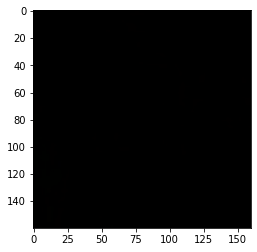

[0] ben_afflek


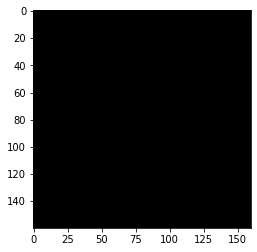

[0] ben_afflek


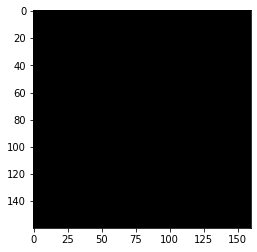

[0] ben_afflek


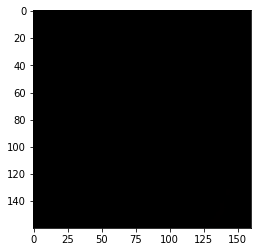

[0] ben_afflek


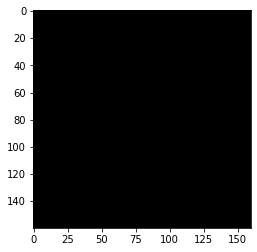

In [27]:
for i in range(X_train.shape[0])[:5]:
    print(y_train[i], names[y_train[i][0]])
    plt.imshow(X_train[i])
    plt.show()

In [19]:
def create_pairs(x, face_indices, num_classes):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(face_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            # positive pairs
            z1, z2 = face_indices[d][i], face_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            # negative pairs
            inc = np.random.randint(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = face_indices[d][i], face_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

# create training+test positive and negative pairs
face_indices = [np.where(y_train == i)[0] for i in range(len(names))]
train_pairs, train_y = create_pairs(X_train, face_indices, num_classes=len(names))

face_indices = [np.where(y_val == i)[0] for i in range(len(names))]
val_pairs, val_y = create_pairs(X_val, face_indices, num_classes=len(names))

In [20]:
train_pairs.shape, train_y.shape, val_pairs.shape, val_y.shape

((130, 2, 160, 160, 3), (130,), (40, 2, 160, 160, 3), (40,))

In [21]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

In [29]:
# build model
# network definition
# 使用 resnet50 當 siamese network base
base_network = keras.applications.resnet50.ResNet50(include_top=False, # 不需要分類層
                                                    weights=None,      # 只需要模型架構，不需要原本的權重
                                                    input_shape=(IMG_SIZE, IMG_SIZE, 3)) # 160x160 的彩圖
# 用 Input() 把圖片變成張量，以利後續模型使用
input_a = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
input_b = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
global_avg = GlobalAveragePooling2D()
processed_a = base_network(input_a) # 得到的是一個立體的feature map
print("經過base network", type(processed_a))
processed_a = global_avg(processed_a) # 也可使用flattern
print("經過global average", type(processed_a))
processed_b = base_network(input_b) # 得到的是一個立體的feature map
processed_b = global_avg(processed_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

經過base network <class 'tensorflow.python.framework.ops.Tensor'>
經過global average <class 'tensorflow.python.framework.ops.Tensor'>


In [30]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
resnet50 (Model)                (None, 5, 5, 2048)   23587712    input_11[0][0]                   
                                                                 input_12[0][0]                   
__________________________________________________________________________________________________
global_average_pooling2d_2 (Glo (None, 2048)         0           resnet50[1][0]             

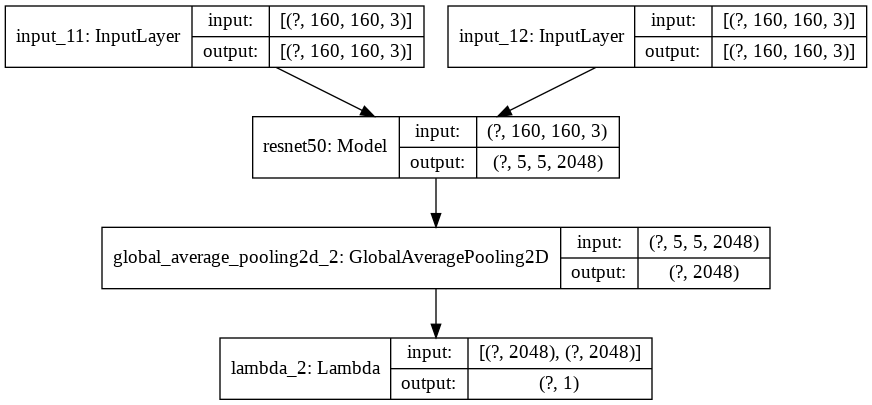

In [31]:
plot_model(model, show_shapes=True)

In [24]:
earlystop = EarlyStopping(patience=10)
model_ckp = ModelCheckpoint(os.path.join('model_siamese.h5'), save_best_only=True, save_weights_only=False)

# train
model.compile(loss=contrastive_loss, optimizer='adam', metrics=[])
model.fit([train_pairs[:, 0], train_pairs[:, 1]], train_y,
          batch_size=32,
          epochs=1000,
          callbacks=[earlystop, model_ckp],
          validation_data=([val_pairs[:, 0], val_pairs[:, 1]], val_y))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 130 samples, validate on 40 samples
Epoch 1/1000
130/130 [==============================] - 27s 204ms/sample - loss: 130.0797 - val_loss: 0.3124
Epoch 2/1000
130/130 [==============================] - 5s 41ms/sample - loss: 43.1484 - val_loss: 0.2919
Epoch 3/1000
130/130 [==============================] - 5s 40ms/sample - loss: 22.2978 - val_loss: 0.2874
Epoch 4/1000
130/130 [==============================] - 5s 40ms/sample - loss: 12.5434 - val_loss: 0.2809
Epoch 5/1000
130/130 [==============================] - 5s 40ms/sample - loss: 6.9798 - val_loss: 0.2741
Epoch 6/1000
130/130 [==============================] - 5s 40ms/sample - loss: 3.8096 - val_loss: 0.2696
Epoch 7/1000
130/130 [==============================] - 5s 40ms/sample - loss: 2.2888 - val_loss: 0.2686
Epoch 8/1000
130/130 [==============================] - 5s 40ms/sample - loss: 1.5694 - val_loss: 0.2686
Epoch 9/1000
1

In [32]:
#Download pretrained model
# 下載老師已經預訓練好的權重
!gdown --id 1JCo1g2sBkG-CwBbqOYlZ1KdGvRcjKTYV -O model.h5

Downloading...
From: https://drive.google.com/uc?id=1JCo1g2sBkG-CwBbqOYlZ1KdGvRcjKTYV
To: /content/model.h5
283MB [00:03, 85.9MB/s]


In [34]:
# load model
# method1: compile=False 不要compile 因為在訓練時用到了客製化的 loss function (自定義的 contrastive_loss) 
# model = load_model('model.h5', compile=False)

# method 2: 把客製化的 loss function 定義回來
model = load_model('model.h5', custom_objects={'contrastive_loss': contrastive_loss})

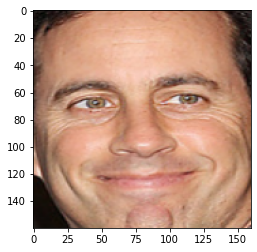

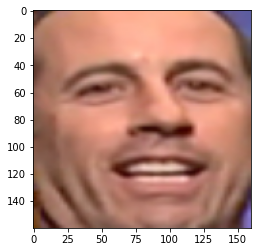

label:  1  val data shape:  (1, 2, 160, 160, 3)
Distance:  [[0.640033]]


In [36]:
# Evaluation
# 可 sample 任一個 pair 秀出AB兩張圖
idx = np.random.randint(0, val_pairs.shape[0])
pair = val_pairs[idx]
label = val_y[idx]
imgA, imgB = pair[0], pair[1]
plt.imshow(imgA)
plt.show()
plt.imshow(imgB)
plt.show()
print('label: ', label, ' val data shape: ',val_pairs[idx:idx+1].shape)
print('Distance: ', model.predict([np.expand_dims(imgA, axis=0), np.expand_dims(imgB, axis=0)]))

In [41]:
all_pairs = np.concatenate((train_pairs, val_pairs))
all_labels = np.concatenate((train_y, val_y))
pprint(all_labels)

array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0])


In [38]:
# np.concatenate 合併的功能，使用測試 
a = np.array([1, 2, 3])
b = np.array([7, 6, 5])
ab = np.concatenate([a,b])
abb = np.concatenate((a,b))
print(ab)
print("-"*30)
print(abb)

[1 2 3 7 6 5]
------------------------------
[1 2 3 7 6 5]


In [40]:
positive_pairs = all_pairs[all_labels == 1]
negative_pairs = all_pairs[all_labels == 0]

In [ ]:
positive_distances = model.predict([positive_pairs[:, 0], positive_pairs[:, 1]])
negative_distances = model.predict([negative_pairs[:, 0], negative_pairs[:, 1]])

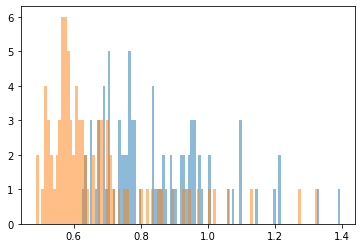

In [ ]:
plt.hist(negative_distances[:,0], bins=100, alpha=0.5)
plt.hist(positive_distances[:,0], bins=100, alpha=0.5)
plt.show()